(1.0, 4.0)

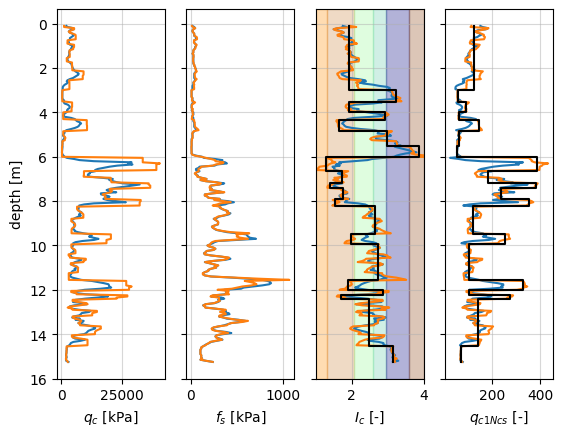

In [1]:
import numpy as np
import json
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import smt

def interleave(v1, v2):
    vout = np.empty(2 * len(v1), dtype=float)
    vout[0::2] = v1
    vout[1::2] = v2
    return vout 

# Read example CPT file
df = pd.read_csv('example_cpt.csv')
depth = df['depth'].values
qc = df['qt'].values
fs = df['fs'].values

# Assign groundwater table depth, average unit weight, and compute vertical total and effective stresses
dGWT = 3.0
gamma = 19.0
sigmav = gamma * depth
u = (depth - dGWT) * 9.81
u[u<0] = 0
sigmavp = sigmav - u

# Use inverse filtering algorithm and layering algorithm to compute layered profile
qt_inv, fs_inv, Ic_inv = smt.cpt_inverse_filter(qc, depth, fs=fs, sigmav=sigmav, sigmavp=sigmavp)
Ic, Qtn, Fr = smt.get_Ic_Qtn_Fr(qc, fs, sigmav, sigmavp)
Ic_inv, Qtn_inv, Fr_inv = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, sigmav, sigmavp)
FC = smt.get_FC_from_Ic(Ic_inv, 0.0)
qc1N, qc1Ncs = smt.get_qc1N_qc1Ncs(qc, fs, sigmav, sigmavp, FC)
qc1N_inv, qc1Ncs_inv = smt.get_qc1N_qc1Ncs(qt_inv, fs_inv, sigmav, sigmavp, FC)
ztop, zbot, qc1Ncs_lay, Ic_lay = smt.cpt_layering(qc1Ncs_inv, Ic_inv, depth, dGWT=dGWT, Nmin=1, Nmax=None)
fig, ax = plt.subplots(ncols=4, sharey='row')

ax[0].plot(qc, depth)
ax[0].plot(qt_inv, depth)
ax[1].plot(fs, depth)
ax[1].plot(fs_inv, depth)
ax[2].plot(Ic, depth)
ax[2].plot(Ic_inv, depth)
ax[3].plot(qc1Ncs, depth)
ax[3].plot(qc1Ncs_inv, depth)
ax[2].axvspan(1,1.31,alpha=0.3,color='darkorange')
ax[2].axvspan(1.31,2.05,alpha=0.3,color='peru')
ax[2].axvspan(2.05,2.6,alpha=0.3,color='palegreen')
ax[2].axvspan(2.6,2.95,alpha=0.3,color='mediumaquamarine')
ax[2].axvspan(2.95,3.6,alpha=0.3,color='navy')
ax[2].axvspan(3.6,4.0,alpha=0.3,color='saddlebrown')
ax[0].set_ylabel('depth [m]')
ax[0].set_xlabel(r'$q_c$ [kPa]')
ax[1].set_xlabel(r'$f_s$ [kPa]')
ax[2].set_xlabel(r'$I_c$ [-]')
ax[3].set_xlabel(r'$q_{c1Ncs}$ [-]')
for a in ax:
    a.grid(True, alpha=0.5)
ax[2].plot(interleave(Ic_lay,Ic_lay), interleave(ztop,zbot), color='black', zorder=2)
ax[3].plot(interleave(qc1Ncs_lay,qc1Ncs_lay), interleave(ztop,zbot), color='black', zorder=2)
ax[0].invert_yaxis()
ax[2].set_xlim(1,4)